<a href="https://colab.research.google.com/github/AhmadYasserHamad/Assignment_4/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [4]:
import pandas as pd
import opendatasets as od
df = pd.read_csv("data.csv")
# Quick look at the dataset
print(df.head())
print(df.info())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [5]:
# drop un named column in data
df = df.drop('Unnamed: 32', axis=1)
print("\nDropped 'Unnamed: 32' column (empty column)")

# Remove non-feature columns (id and diagnosis for unsupervised learning) and id have no meaning
X = df.drop(['id', 'diagnosis'], axis=1, errors='ignore')

print(f"\nRemaining columns: {X.columns.tolist()}")
print(f"Features shape: {X.shape}")

# Normalize the features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convert back to DataFrame for easier viewing
normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

print("\n" + "="*50)
print("NORMALIZATION COMPLETE")
print("="*50)
print(f"\nOriginal data statistics:")
print(X.describe())
print(f"\nNormalized data statistics:")
print(normalized_df.describe())

print(f"\nNormalized data shape: {X_normalized.shape}")

# Display first few rows of normalized data
print("\nFirst 5 rows of normalized data:")
print(normalized_df.head())


Dropped 'Unnamed: 32' column (empty column)

Remaining columns: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Features shape: (569, 30)

NORMALIZATION COMPLETE

Original data statistics:
       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   1

class of gmm

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal

class GaussianMixtureModel:
    """
    Gaussian Mixture Model implementation using only NumPy
    """
    def __init__(
        self,
        n_components: int = 2,
        covariance_type: Literal['full', 'diagonal', 'spherical', 'tied'] = 'full',
        init_method: Literal['kmeans++', 'random'] = 'kmeans++',
        tol: float = 1e-4,
        max_iter: int = 100,
        random_state: int = None
    ):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.init_method = init_method
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state

        # Parameters to be learned
        self.means_ = None          # Shape: (n_components, n_features)
        self.covariances_ = None    # Shape depends on covariance_type
        self.weights_ = None        # Shape: (n_components,)

        # Training info
        self.converged_ = False
        self.n_iter_ = 0
        self.log_likelihood_history_ = []

        # Set random seed if provided
        if random_state is not None:
            np.random.seed(random_state)

    def _kmeans_plus_plus(self, X):
        """
        Initialize centers using k-means++ algorithm
        """
        n_samples, n_features = X.shape
        centers = np.zeros((self.n_components, n_features))

        # Step 1: Choose first center randomly from data points
        first_idx = np.random.randint(0, n_samples)
        centers[0] = X[first_idx]

        # Step 2: Choose remaining centers with probability proportional to distance squared
        for i in range(1, self.n_components):
            # Compute squared distances from each point to nearest existing center
            distances = np.zeros(n_samples)

            for j in range(n_samples):
                # Distance to nearest center
                min_dist = float('inf')
                for k in range(i):
                    dist = np.sum((X[j] - centers[k]) ** 2)
                    min_dist = min(min_dist, dist)
                distances[j] = min_dist

            # Choose next center with probability proportional to distance squared
            probabilities = distances / distances.sum()
            next_idx = np.random.choice(n_samples, p=probabilities)
            centers[i] = X[next_idx]

        return centers

    def _initialize_parameters(self, X):
        """
        Initialize means, covariances, and weights for GMM
        """
        n_samples, n_features = X.shape

        # Initialize means using k-means++
        if self.init_method == 'kmeans++':
            self.means_ = self._kmeans_plus_plus(X)
        else:
            # Random initialization (select random points from data)
            indices = np.random.choice(n_samples, self.n_components, replace=False)
            self.means_ = X[indices]

        # Initialize covariances based on covariance_type
        if self.covariance_type == 'full':
            # Full covariance matrix for each component
            # Shape: (n_components, n_features, n_features)
            self.covariances_ = np.array([np.cov(X.T) for _ in range(self.n_components)])

        elif self.covariance_type == 'diagonal':
            # Diagonal covariance (only variances, no covariances)
            # Shape: (n_components, n_features)
            self.covariances_ = np.array([np.var(X, axis=0) for _ in range(self.n_components)])

        elif self.covariance_type == 'spherical':
            # Spherical covariance (single variance for all dimensions)
            # Shape: (n_components,)
            self.covariances_ = np.array([np.mean(np.var(X, axis=0)) for _ in range(self.n_components)])

        elif self.covariance_type == 'tied':
            # Tied covariance (single shared covariance matrix for all components)
            # Shape: (n_features, n_features)
            self.covariances_ = np.cov(X.T)

        # Initialize weights (mixing coefficients) - uniform distribution
        self.weights_ = np.ones(self.n_components) / self.n_components

        print(f"Initialized parameters:")
        print(f"  Means shape: {self.means_.shape}")
        print(f"  Covariances shape: {self.covariances_.shape}")
        print(f"  Weights shape: {self.weights_.shape}")

    def _compute_gaussian_pdf(self, X, mean, covariance):
        """
        Compute the probability density function of multivariate Gaussian distribution (for single component)
        Returns:
        --------
        pdf : np.ndarray, shape (n_samples,)
            Probability density for each data point
        """
        n_samples, n_features = X.shape

        # Center the data
        X_centered = X - mean  # Shape: (n_samples, n_features)

        if self.covariance_type == 'full':
            # Full covariance matrix: shape (n_features, n_features)
            # Add small regularization to avoid singular matrix
            cov_reg = covariance + 1e-6 * np.eye(n_features)

            # Compute determinant and inverse
            cov_det = np.linalg.det(cov_reg)
            cov_inv = np.linalg.inv(cov_reg)

            # Mahalanobis distance: (x - μ)^T Σ^(-1) (x - μ)
            mahal_dist = np.sum(X_centered @ cov_inv * X_centered, axis=1)

            # Normalization constant
            norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * cov_det)

        elif self.covariance_type == 'diagonal':
            # Diagonal covariance: shape (n_features,)
            # Add regularization
            cov_reg = covariance + 1e-6

            # Compute determinant (product of diagonal elements)
            cov_det = np.prod(cov_reg)

            # Mahalanobis distance with diagonal covariance
            mahal_dist = np.sum(X_centered ** 2 / cov_reg, axis=1)

            # Normalization constant
            norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * cov_det)

        elif self.covariance_type == 'spherical':
            # Spherical covariance: scalar
            # Add regularization
            cov_reg = covariance + 1e-6

            # Compute determinant (variance to the power of n_features)
            cov_det = cov_reg ** n_features

            # Mahalanobis distance with spherical covariance
            mahal_dist = np.sum(X_centered ** 2, axis=1) / cov_reg

            # Normalization constant
            norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * cov_det)

        elif self.covariance_type == 'tied':
            # Tied covariance: shape (n_features, n_features)
            # Same as full, but this matrix is shared across all components
            cov_reg = covariance + 1e-6 * np.eye(n_features)

            cov_det = np.linalg.det(cov_reg)
            cov_inv = np.linalg.inv(cov_reg)

            mahal_dist = np.sum(X_centered @ cov_inv * X_centered, axis=1)
            norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * cov_det)

        # Compute PDF using the formula: N(x|μ,Σ) = (1/√((2π)^k|Σ|)) * exp(-0.5 * mahal_dist)
        pdf = norm_const * np.exp(-0.5 * mahal_dist)

        return pdf

    def _e_step(self, X):
        """
        E-step: Compute responsibilities (posterior probabilities)
        For each data point x_i and component k, compute:
        γ(z_ik) = π_k * N(x_i | μ_k, Σ_k) / Σ_j[π_j * N(x_i | μ_j, Σ_j)]
        Uses log-space computation for numerical stability.
        responsibilities : np.ndarray, shape (n_samples, n_components)
            Posterior probabilities that each sample belongs to each component
        """
        n_samples = X.shape[0]

        # Compute log weighted likelihoods for numerical stability
        # log_weighted_likelihoods[i, k] = log(π_k) + log(N(x_i | μ_k, Σ_k))
        log_weighted_likelihoods = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            # Get covariance for component k
            if self.covariance_type == 'tied':
                # All components share the same covariance
                cov = self.covariances_
            elif self.covariance_type == 'full' or self.covariance_type == 'diagonal':
                cov = self.covariances_[k]
            elif self.covariance_type == 'spherical':
                cov = self.covariances_[k]

            # Compute PDF for component k
            pdf = self._compute_gaussian_pdf(X, self.means_[k], cov)

            # Compute log weighted likelihood: log(π_k) + log(N(x_i | μ_k, Σ_k))
            # Add small epsilon to avoid log(0)
            log_weighted_likelihoods[:, k] = np.log(self.weights_[k] + 1e-10) + np.log(pdf + 1e-10)

        # Use log-sum-exp trick for numerical stability
        # log(sum(exp(x_i))) = max(x) + log(sum(exp(x_i - max(x))))
        max_log = np.max(log_weighted_likelihoods, axis=1, keepdims=True)
        log_sum_exp = max_log + np.log(np.sum(np.exp(log_weighted_likelihoods - max_log), axis=1, keepdims=True))

        # Compute log responsibilities
        log_responsibilities = log_weighted_likelihoods - log_sum_exp

        # Convert back from log space
        responsibilities = np.exp(log_responsibilities)

        return responsibilities

    def _m_step(self, X, responsibilities):
        """
        M-step: Update parameters based on responsibilitie
        """
        n_samples, n_features = X.shape

        # Compute effective number of points assigned to each component
        # N_k = Σ_i γ(z_ik)
        N_k = responsibilities.sum(axis=0)  # Shape: (n_components,)

        # Update weights (mixing coefficients)
        # π_k = N_k / N
        self.weights_ = N_k / n_samples

        # Update means
        # μ_k = (1/N_k) * Σ_i γ(z_ik) * x_i
        for k in range(self.n_components):
            # Weighted sum of data points
            weighted_sum = np.sum(responsibilities[:, k].reshape(-1, 1) * X, axis=0)
            self.means_[k] = weighted_sum / N_k[k]

        # Update covariances based on covariance type
        if self.covariance_type == 'full':
            # Full covariance matrix for each component
            # Σ_k = (1/N_k) * Σ_i γ(z_ik) * (x_i - μ_k)(x_i - μ_k)^T
            for k in range(self.n_components):
                # Center the data
                X_centered = X - self.means_[k]  # Shape: (n_samples, n_features)

                # Weight each centered point by its responsibility
                weighted_X_centered = responsibilities[:, k].reshape(-1, 1) * X_centered

                # Compute covariance: Σ_k = (1/N_k) * X_centered^T * weighted_X_centered
                self.covariances_[k] = (X_centered.T @ weighted_X_centered) / N_k[k]

                # Add regularization to ensure positive definite matrix
                self.covariances_[k] += 1e-6 * np.eye(n_features)

        elif self.covariance_type == 'diagonal':
            # Diagonal covariance (only variances)
            # Σ_k = (1/N_k) * Σ_i γ(z_ik) * (x_i - μ_k)^2
            for k in range(self.n_components):
                X_centered = X - self.means_[k]
                weighted_sq_diff = responsibilities[:, k].reshape(-1, 1) * (X_centered ** 2)
                self.covariances_[k] = np.sum(weighted_sq_diff, axis=0) / N_k[k]

                # Add regularization
                self.covariances_[k] += 1e-6

        elif self.covariance_type == 'spherical':
            # Spherical covariance (single variance value)
            # Σ_k = (1/(N_k * d)) * Σ_i γ(z_ik) * ||x_i - μ_k||^2
            for k in range(self.n_components):
                X_centered = X - self.means_[k]
                weighted_sq_dist = responsibilities[:, k] * np.sum(X_centered ** 2, axis=1)
                self.covariances_[k] = np.sum(weighted_sq_dist) / (N_k[k] * n_features)

                # Add regularization
                self.covariances_[k] += 1e-6

        elif self.covariance_type == 'tied':
            # Tied covariance (single shared covariance matrix for all components)
            # Σ = (1/N) * Σ_k Σ_i γ(z_ik) * (x_i - μ_k)(x_i - μ_k)^T
            self.covariances_ = np.zeros((n_features, n_features))

            for k in range(self.n_components):
                X_centered = X - self.means_[k]
                weighted_X_centered = responsibilities[:, k].reshape(-1, 1) * X_centered
                self.covariances_ += X_centered.T @ weighted_X_centered

            self.covariances_ /= n_samples

            # Add regularization
            self.covariances_ += 1e-6 * np.eye(n_features)

    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data given current parameters
        log L = Σ_i log(Σ_k π_k * N(x_i | μ_k, Σ_k))
        Returns:
        log_likelihood : float
            Log-likelihood of the data
        """
        n_samples = X.shape[0]
        log_likelihood = 0.0

        for i in range(n_samples):
            # Compute weighted likelihood for sample i across all components
            sample_likelihood = 0.0

            for k in range(self.n_components):
                # Get covariance for component k
                if self.covariance_type == 'tied':
                    cov = self.covariances_
                else:
                    cov = self.covariances_[k]

                # Compute PDF
                pdf = self._compute_gaussian_pdf(X[i:i+1], self.means_[k], cov)

                # Add weighted likelihood
                sample_likelihood += self.weights_[k] * pdf[0]

            # Add log of likelihood (with small epsilon to avoid log(0))
            log_likelihood += np.log(sample_likelihood + 1e-10)

        return log_likelihood

    def fit(self, X, verbose=True):
        """
        Fit the Gaussian Mixture Model using the EM algorithm
        Returns
        self : GaussianMixtureModel
            Fitted model
        """
        n_samples, n_features = X.shape

        if verbose:
            print("="*70)
            print(f"FITTING GAUSSIAN MIXTURE MODEL")
            print("="*70)
            print(f"Data shape: {X.shape}")
            print(f"Number of components: {self.n_components}")
            print(f"Covariance type: {self.covariance_type}")
            print(f"Initialization method: {self.init_method}")
            print(f"Max iterations: {self.max_iter}")
            print(f"Tolerance: {self.tol}")
            print("="*70)

        # Initialize parameters
        self._initialize_parameters(X)

        # Compute initial log-likelihood
        prev_log_likelihood = self._compute_log_likelihood(X)
        self.log_likelihood_history_.append(prev_log_likelihood)

        if verbose:
            print(f"\nInitial log-likelihood: {prev_log_likelihood:.4f}")
            print("\nStarting EM iterations...")
            print("-"*70)

        # EM algorithm loop
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._e_step(X)

            # M-step: Update parameters
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            current_log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihood_history_.append(current_log_likelihood)

            # Check convergence
            log_likelihood_change = current_log_likelihood - prev_log_likelihood

            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1:3d}: Log-likelihood = {current_log_likelihood:.4f}, "
                      f"Change = {log_likelihood_change:.6f}")

            # Check for convergence
            if abs(log_likelihood_change) < self.tol:
                self.converged_ = True
                self.n_iter_ = iteration + 1
                if verbose:
                    print("-"*70)
                    print(f"✓ Converged at iteration {iteration + 1}")
                    print(f"  Final log-likelihood: {current_log_likelihood:.4f}")
                    print(f"  Log-likelihood change: {log_likelihood_change:.6f}")
                break

            prev_log_likelihood = current_log_likelihood
            self.n_iter_ = iteration + 1

        # If max iterations reached without convergence
        if not self.converged_:
            if verbose:
                print("-"*70)
                print(f"✗ Did not converge after {self.max_iter} iterations")
                print(f"  Final log-likelihood: {current_log_likelihood:.4f}")
                print(f"  Final change: {log_likelihood_change:.6f}")

        if verbose:
            print("="*70)
            print("TRAINING COMPLETE")
            print("="*70)
            print(f"Converged: {self.converged_}")
            print(f"Iterations: {self.n_iter_}")
            print(f"Final weights: {self.weights_}")
            print("="*70)

        return self

    def predict(self, X):
        """
        Predict the component labels for data samples (hard assignment)
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """
        Predict posterior probabilities for data samples (soft assignment)
        """
        return self._e_step(X)

    def score(self, X):
        """
        Compute the log-likelihood of the data
        """
        return self._compute_log_likelihood(X)

In [45]:
# Test the GMM initialization with your normalized data

print("="*70)
print("TESTING GMM INITIALIZATION")
print("="*70)

# Test 1: Full covariance with k-means++
print("\n" + "="*70)
print("TEST 1: Full Covariance + K-means++")
print("="*70)
gmm_full = GaussianMixtureModel(
    n_components=2,
    covariance_type='full',
    init_method='kmeans++',
    random_state=42
)
gmm_full._initialize_parameters(X_normalized)
print(f"\nMeans:\n{gmm_full.means_}")
print(f"\nWeights: {gmm_full.weights_}")
print(f"\nCovariances shape: {gmm_full.covariances_.shape}")
print(f"First covariance matrix (first 5x5):\n{gmm_full.covariances_[0][:5, :5]}")

# Test 2: Diagonal covariance with k-means++
print("\n" + "="*70)
print("TEST 2: Diagonal Covariance + K-means++")
print("="*70)
gmm_diag = GaussianMixtureModel(
    n_components=2,
    covariance_type='diagonal',
    init_method='kmeans++',
    random_state=42
)
gmm_diag._initialize_parameters(X_normalized)
print(f"\nMeans:\n{gmm_diag.means_}")
print(f"\nWeights: {gmm_diag.weights_}")
print(f"\nCovariances shape: {gmm_diag.covariances_.shape}")
print(f"First component covariances (first 10 features):\n{gmm_diag.covariances_[0][:10]}")

# Test 3: Spherical covariance with k-means++
print("\n" + "="*70)
print("TEST 3: Spherical Covariance + K-means++")
print("="*70)
gmm_spher = GaussianMixtureModel(
    n_components=2,
    covariance_type='spherical',
    init_method='kmeans++',
    random_state=42
)
gmm_spher._initialize_parameters(X_normalized)
print(f"\nMeans:\n{gmm_spher.means_}")
print(f"\nWeights: {gmm_spher.weights_}")
print(f"\nCovariances shape: {gmm_spher.covariances_.shape}")
print(f"Covariances (scalar for each component): {gmm_spher.covariances_}")

# Test 4: Tied covariance with k-means++
print("\n" + "="*70)
print("TEST 4: Tied Covariance + K-means++")
print("="*70)
gmm_tied = GaussianMixtureModel(
    n_components=2,
    covariance_type='tied',
    init_method='kmeans++',
    random_state=42
)
gmm_tied._initialize_parameters(X_normalized)
print(f"\nMeans:\n{gmm_tied.means_}")
print(f"\nWeights: {gmm_tied.weights_}")
print(f"\nCovariances shape: {gmm_tied.covariances_.shape}")
print(f"Tied covariance matrix (first 5x5):\n{gmm_tied.covariances_[:5, :5]}")

# Verify that means are different but initialized from data
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)
print(f"Data shape: {X_normalized.shape}")
print(f"Data min: {X_normalized.min():.3f}, max: {X_normalized.max():.3f}")
print(f"\nAll weights sum to 1.0: {np.allclose(gmm_full.weights_.sum(), 1.0)}")
print(f"Means are from data range: {(gmm_full.means_.min() >= X_normalized.min() and gmm_full.means_.max() <= X_normalized.max())}")

TESTING GMM INITIALIZATION

TEST 1: Full Covariance + K-means++
Initialized parameters:
  Means shape: (2, 30)
  Covariances shape: (2, 30, 30)
  Weights shape: (2,)

Means:
[[-0.5530585   0.28631105 -0.60751564 -0.55798194 -1.15503513 -1.21215527
  -0.81568788 -0.8052661  -0.2651265  -0.85447642 -0.76793904  0.64254367
  -0.83316584 -0.5644996  -0.65368614 -1.08314703 -0.70305211 -0.81090835
  -0.73522485 -0.85594642 -0.60658404  1.16641373 -0.67557894 -0.58500369
  -0.87972471 -1.05373391 -0.75651421 -0.61357437 -0.33448538 -0.84042616]
 [ 1.71905507  0.05825847  1.72302589  1.69255646  1.20552258  0.84445927
   1.56310249  1.98564279 -0.31989066 -0.32145729  0.10079781 -0.39163235
   0.07026503  0.26738504  0.68203468  0.09343955  0.78138781  1.18475716
   0.48040333  0.07946914  1.19296315 -0.09888253  1.15386726  1.05196463
   1.4961806   0.25404212  1.24069484  1.56367679  0.21232446 -0.17709882]]

Weights: [0.5 0.5]

Covariances shape: (2, 30, 30)
First covariance matrix (first 

In [46]:
print("\n" + "="*70)
print("TESTING E-STEP (EXPECTATION) - FULL COVARIANCE ONLY")
print("="*70)

# Initialize GMM with full covariance
gmm_test = GaussianMixtureModel(
    n_components=2,
    covariance_type='full',
    init_method='kmeans++',
    random_state=42
)
gmm_test._initialize_parameters(X_normalized)

# Compute responsibilities
responsibilities = gmm_test._e_step(X_normalized)

print(f"\nResponsibilities shape: {responsibilities.shape}")
print(f"Expected shape: ({X_normalized.shape[0]}, {gmm_test.n_components})")

# Check first 10 samples
print(f"\nFirst 10 samples responsibilities:")
print(responsibilities[:10])

# Verify properties
print("\n" + "-"*70)
print("VERIFICATION CHECKS:")
print("-"*70)

# Check 1: Each row should sum to 1
row_sums = responsibilities.sum(axis=1)
print(f"✓ All rows sum to 1.0: {np.allclose(row_sums, 1.0)}")
print(f"  Min row sum: {row_sums.min():.10f}, Max row sum: {row_sums.max():.10f}")

# Check 2: Values should be between 0 and 1
print(f"✓ All values in [0, 1]: {(responsibilities >= 0).all() and (responsibilities <= 1).all()}")
print(f"  Min value: {responsibilities.min():.10f}, Max value: {responsibilities.max():.10f}")

# Check 3: Distribution of responsibilities
print(f"\n✓ Responsibility statistics:")
print(f"  Component 0 - Mean: {responsibilities[:, 0].mean():.4f}, Std: {responsibilities[:, 0].std():.4f}")
print(f"  Component 1 - Mean: {responsibilities[:, 1].mean():.4f}, Std: {responsibilities[:, 1].std():.4f}")

# Check 4: Hard assignments (which component has higher responsibility)
hard_assignments = np.argmax(responsibilities, axis=1)
unique, counts = np.unique(hard_assignments, return_counts=True)
print(f"\n✓ Hard cluster assignments:")
for comp, count in zip(unique, counts):
    print(f"  Component {comp}: {count} samples ({count/len(hard_assignments)*100:.1f}%)")

# Check 5: Show some "confident" and "uncertain" assignments
component_0_resp = responsibilities[:, 0]
print(f"\n✓ Sample assignments:")
print(f"  Most confident for Component 0 (resp ≈ 1.0):")
most_confident_0 = np.argsort(component_0_resp)[-5:]
for idx in most_confident_0:
    print(f"    Sample {idx}: Component 0 = {responsibilities[idx, 0]:.6f}, Component 1 = {responsibilities[idx, 1]:.6f}")

print(f"\n  Most confident for Component 1 (resp ≈ 1.0):")
most_confident_1 = np.argsort(component_0_resp)[:5]
for idx in most_confident_1:
    print(f"    Sample {idx}: Component 0 = {responsibilities[idx, 0]:.6f}, Component 1 = {responsibilities[idx, 1]:.6f}")

print(f"\n  Most uncertain (resp ≈ 0.5):")
uncertainty = np.abs(component_0_resp - 0.5)
most_uncertain = np.argsort(uncertainty)[:5]
for idx in most_uncertain:
    print(f"    Sample {idx}: Component 0 = {responsibilities[idx, 0]:.6f}, Component 1 = {responsibilities[idx, 1]:.6f}")


TESTING E-STEP (EXPECTATION) - FULL COVARIANCE ONLY
Initialized parameters:
  Means shape: (2, 30)
  Covariances shape: (2, 30, 30)
  Weights shape: (2,)

Responsibilities shape: (569, 2)
Expected shape: (569, 2)

First 10 samples responsibilities:
[[5.00000000e-01 5.00000000e-01]
 [9.98555177e-01 1.44482280e-03]
 [2.36804025e-02 9.76319597e-01]
 [5.00000000e-01 5.00000000e-01]
 [2.97001103e-04 9.99702999e-01]
 [8.54587483e-01 1.45412517e-01]
 [9.78065441e-01 2.19345592e-02]
 [9.99991342e-01 8.65751892e-06]
 [9.99834722e-01 1.65277666e-04]
 [5.00000000e-01 5.00000000e-01]]

----------------------------------------------------------------------
VERIFICATION CHECKS:
----------------------------------------------------------------------
✓ All rows sum to 1.0: True
  Min row sum: 1.0000000000, Max row sum: 1.0000000000
✓ All values in [0, 1]: True
  Min value: 0.0000000001, Max value: 0.9999999999

✓ Responsibility statistics:
  Component 0 - Mean: 0.7750, Std: 0.3266
  Component 1 - Mean

In [47]:
print("\n" + "="*70)
print("TESTING M-STEP (MAXIMIZATION) - FULL COVARIANCE")
print("="*70)

# Initialize GMM with full covariance
gmm_test = GaussianMixtureModel(
    n_components=2,
    covariance_type='full',
    init_method='kmeans++',
    random_state=42
)

print("\n" + "-"*70)
print("STEP 1: Initialize Parameters")
print("-"*70)
gmm_test._initialize_parameters(X_normalized)

# Store initial parameters
initial_means = gmm_test.means_.copy()
initial_covariances = gmm_test.covariances_.copy()
initial_weights = gmm_test.weights_.copy()

print(f"\nInitial means (first component, first 5 features):")
print(initial_means[0, :5])
print(f"\nInitial weights: {initial_weights}")
print(f"\nInitial covariance shape: {initial_covariances.shape}")

# Compute responsibilities (E-step)
print("\n" + "-"*70)
print("STEP 2: E-step - Compute Responsibilities")
print("-"*70)
responsibilities = gmm_test._e_step(X_normalized)
print(f"Responsibilities shape: {responsibilities.shape}")
print(f"First 5 samples responsibilities:")
print(responsibilities[:5])

# Update parameters (M-step)
print("\n" + "-"*70)
print("STEP 3: M-step - Update Parameters")
print("-"*70)
gmm_test._m_step(X_normalized, responsibilities)

# Store updated parameters
updated_means = gmm_test.means_.copy()
updated_covariances = gmm_test.covariances_.copy()
updated_weights = gmm_test.weights_.copy()

print(f"\nUpdated means (first component, first 5 features):")
print(updated_means[0, :5])
print(f"\nUpdated weights: {updated_weights}")
print(f"\nUpdated covariance shape: {updated_covariances.shape}")

# Check that parameters changed
print("\n" + "-"*70)
print("VERIFICATION: Parameters Changed?")
print("-"*70)

means_changed = not np.allclose(initial_means, updated_means)
weights_changed = not np.allclose(initial_weights, updated_weights)
covariances_changed = not np.allclose(initial_covariances, updated_covariances)

print(f"✓ Means changed: {means_changed}")
if means_changed:
    mean_diff = np.abs(updated_means - initial_means).max()
    print(f"  Max absolute change in means: {mean_diff:.6f}")

print(f"\n✓ Weights changed: {weights_changed}")
if weights_changed:
    weight_diff = np.abs(updated_weights - initial_weights)
    print(f"  Weight changes: {weight_diff}")
    print(f"  Initial weights: {initial_weights}")
    print(f"  Updated weights: {updated_weights}")

print(f"\n✓ Covariances changed: {covariances_changed}")
if covariances_changed:
    cov_diff = np.abs(updated_covariances - initial_covariances).max()
    print(f"  Max absolute change in covariances: {cov_diff:.6f}")

# Verify weights sum to 1
print("\n" + "-"*70)
print("VERIFICATION: Weights Properties")
print("-"*70)
print(f"✓ Weights sum to 1.0: {np.allclose(updated_weights.sum(), 1.0)}")
print(f"  Actual sum: {updated_weights.sum():.10f}")
print(f"✓ All weights > 0: {(updated_weights > 0).all()}")
print(f"✓ All weights < 1: {(updated_weights < 1).all()}")

# Verify covariances are positive definite
print("\n" + "-"*70)
print("VERIFICATION: Covariance Properties")
print("-"*70)
for k in range(gmm_test.n_components):
    eigenvalues = np.linalg.eigvals(updated_covariances[k])
    is_positive_definite = (eigenvalues > 0).all()
    print(f"✓ Component {k} covariance is positive definite: {is_positive_definite}")
    print(f"  Min eigenvalue: {eigenvalues.min():.6e}")
    print(f"  Max eigenvalue: {eigenvalues.max():.6e}")

# Run multiple EM iterations to see convergence
print("\n" + "="*70)
print("TESTING MULTIPLE EM ITERATIONS")
print("="*70)

gmm_iter = GaussianMixtureModel(
    n_components=2,
    covariance_type='full',
    init_method='kmeans++',
    random_state=42
)
gmm_iter._initialize_parameters(X_normalized)

print("\nRunning 5 EM iterations...")
for iteration in range(5):
    # E-step
    resp = gmm_iter._e_step(X_normalized)

    # M-step
    gmm_iter._m_step(X_normalized, resp)

    print(f"\nIteration {iteration + 1}:")
    print(f"  Weights: {gmm_iter.weights_}")
    print(f"  Mean[0] (first 3 features): {gmm_iter.means_[0, :3]}")


TESTING M-STEP (MAXIMIZATION) - FULL COVARIANCE

----------------------------------------------------------------------
STEP 1: Initialize Parameters
----------------------------------------------------------------------
Initialized parameters:
  Means shape: (2, 30)
  Covariances shape: (2, 30, 30)
  Weights shape: (2,)

Initial means (first component, first 5 features):
[-0.5530585   0.28631105 -0.60751564 -0.55798194 -1.15503513]

Initial weights: [0.5 0.5]

Initial covariance shape: (2, 30, 30)

----------------------------------------------------------------------
STEP 2: E-step - Compute Responsibilities
----------------------------------------------------------------------
Responsibilities shape: (569, 2)
First 5 samples responsibilities:
[[5.00000000e-01 5.00000000e-01]
 [9.98555177e-01 1.44482280e-03]
 [2.36804025e-02 9.76319597e-01]
 [5.00000000e-01 5.00000000e-01]
 [2.97001103e-04 9.99702999e-01]]

----------------------------------------------------------------------
STEP 

final test


TESTING COMPLETE GMM IMPLEMENTATION

TEST 1: Fit GMM with Full Covariance
FITTING GAUSSIAN MIXTURE MODEL
Data shape: (569, 30)
Number of components: 2
Covariance type: full
Initialization method: kmeans++
Max iterations: 100
Tolerance: 0.0001
Initialized parameters:
  Means shape: (2, 30)
  Covariances shape: (2, 30, 30)
  Weights shape: (2,)

Initial log-likelihood: -5999.7426

Starting EM iterations...
----------------------------------------------------------------------
Iteration  10: Log-likelihood = -1228.0862, Change = 19.353319
Iteration  20: Log-likelihood = -1142.1797, Change = -0.286633
Iteration  30: Log-likelihood = -1126.0376, Change = 0.751830
Iteration  40: Log-likelihood = -1117.9027, Change = -0.031370
Iteration  50: Log-likelihood = -1117.8907, Change = 0.009440
Iteration  60: Log-likelihood = -1117.8688, Change = 0.000292
----------------------------------------------------------------------
✓ Converged at iteration 64
  Final log-likelihood: -1117.8683
  Log-likel

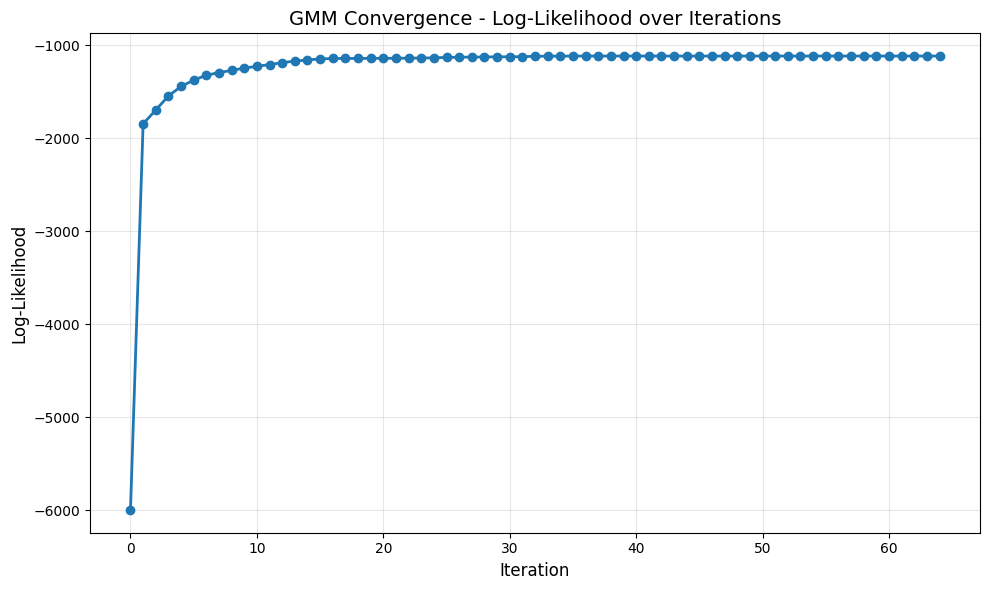

✓ Plotted log-likelihood convergence

TEST 5: Final Model Properties

Converged: True
Number of iterations: 64

Final component weights: [0.68958108 0.31041892]

Means shape: (2, 30)
Component 0 mean (first 5 features): [-0.41152084 -0.20875672 -0.42068568 -0.40175135 -0.22174502]
Component 1 mean (first 5 features): [0.91417426 0.46374326 0.93453352 0.8924718  0.49259616]

Covariances shape: (2, 30, 30)

Component 0 covariance:
  Min eigenvalue: 7.985083e-05
  Max eigenvalue: 7.560221e+00
  Condition number: 94679.30

Component 1 covariance:
  Min eigenvalue: 2.254649e-04
  Max eigenvalue: 9.031683e+00
  Condition number: 40058.04

TEST 6: Comparison with True Labels

Confusion Matrix:
[[348   9]
 [ 53 159]]

Adjusted Rand Index: 0.6068
Best matching accuracy: 0.8910 (89.10%)

ALL TESTS COMPLETED SUCCESSFULLY!


In [48]:
print("\n" + "="*70)
print("TESTING COMPLETE GMM IMPLEMENTATION")
print("="*70)

# Test 1: Fit the model with full covariance
print("\n" + "="*70)
print("TEST 1: Fit GMM with Full Covariance")
print("="*70)

gmm_full = GaussianMixtureModel(
    n_components=2,
    covariance_type='full',
    init_method='kmeans++',
    tol=1e-4,
    max_iter=100,
    random_state=42
)

# Fit the model
gmm_full.fit(X_normalized, verbose=True)

# Test 2: Make predictions
print("\n" + "="*70)
print("TEST 2: Predictions")
print("="*70)

# Hard predictions
labels = gmm_full.predict(X_normalized)
print(f"\nHard predictions (labels) shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")
print(f"First 20 predictions: {labels[:20]}")

# Count samples per cluster
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\nCluster distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} samples ({count/len(labels)*100:.1f}%)")

# Soft predictions (probabilities)
probabilities = gmm_full.predict_proba(X_normalized)
print(f"\nSoft predictions (probabilities) shape: {probabilities.shape}")
print(f"First 5 samples probabilities:")
print(probabilities[:5])

# Test 3: Score (log-likelihood)
print("\n" + "="*70)
print("TEST 3: Model Score")
print("="*70)

score = gmm_full.score(X_normalized)
print(f"Final log-likelihood: {score:.4f}")
print(f"Log-likelihood history length: {len(gmm_full.log_likelihood_history_)}")

# Test 4: Visualize log-likelihood convergence
print("\n" + "="*70)
print("TEST 4: Convergence Visualization")
print("="*70)

plt.figure(figsize=(10, 6))
plt.plot(gmm_full.log_likelihood_history_, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.title('GMM Convergence - Log-Likelihood over Iterations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Plotted log-likelihood convergence")

# Test 5: Model properties
print("\n" + "="*70)
print("TEST 5: Final Model Properties")
print("="*70)

print(f"\nConverged: {gmm_full.converged_}")
print(f"Number of iterations: {gmm_full.n_iter_}")
print(f"\nFinal component weights: {gmm_full.weights_}")
print(f"\nMeans shape: {gmm_full.means_.shape}")
print(f"Component 0 mean (first 5 features): {gmm_full.means_[0, :5]}")
print(f"Component 1 mean (first 5 features): {gmm_full.means_[1, :5]}")
print(f"\nCovariances shape: {gmm_full.covariances_.shape}")

# Check covariance properties
for k in range(gmm_full.n_components):
    eigenvalues = np.linalg.eigvals(gmm_full.covariances_[k])
    print(f"\nComponent {k} covariance:")
    print(f"  Min eigenvalue: {eigenvalues.min():.6e}")
    print(f"  Max eigenvalue: {eigenvalues.max():.6e}")
    print(f"  Condition number: {eigenvalues.max() / eigenvalues.min():.2f}")

# Test 6: Compare with actual labels (if available in original data)
if 'diagnosis' in df.columns:
    print("\n" + "="*70)
    print("TEST 6: Comparison with True Labels")
    print("="*70)

    # Get true labels
    true_labels = df['diagnosis'].map({'M': 1, 'B': 0}).values

    # Compare with predictions
    from sklearn.metrics import confusion_matrix, adjusted_rand_score

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, labels)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Compute Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, labels)
    print(f"\nAdjusted Rand Index: {ari:.4f}")

    # Compute accuracy (may need to flip labels)
    accuracy1 = np.mean(labels == true_labels)
    accuracy2 = np.mean(labels == (1 - true_labels))
    best_accuracy = max(accuracy1, accuracy2)
    print(f"Best matching accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print("\n" + "="*70)
print("ALL TESTS COMPLETED SUCCESSFULLY!")
print("="*70)